In [96]:
# notebook-specific installs
!pip install textdistance
!pip install python-Levenshtein
!pip install seaborn

You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pip' command.
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
heritage-connector-nlp 0.1.0 requires label-studio==0.8.1, which is not installed.
heritage-connector-nlp 0.1.0 requires spacy<2.4.0,>=2.3.0, which is not installed.
heritage-connector-nlp 0.1.0 requires jupyterlab==2.2.9, but you have jupyterlab 3.0.5 which is incompatible.
heritage-connector-nlp 0.1.0 requires seaborn==0.11.0, but you have seaborn 0.11.1 which is incompatible.
You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pi

# Mentions experiment

Can we link entity mentions together only using their similarity to each other, ignoring their context?

In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../..")

from heritageconnector.datastore import es, index
import json
import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import textdistance

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_path = "../data/test_data_None.jsonl"

json_list = utils.load_jsonld_dump(data_path)

print(len(json_list))
json_list[0]

297425


{'_index': 'heritageconnector',
 '_type': '_doc',
 '_id': 'https://collection.sciencemuseumgroup.org.uk/objects/co8027145',
 '_score': 1.9999925,
 '_source': {'uri': 'https://collection.sciencemuseumgroup.org.uk/objects/co8027145',
  'collection': 'SMG',
  'type': 'OBJECT',
  'data': {'http://www.w3.org/2001/XMLSchema#description': 'Poster, British Railways (Southern) poster, (Weekend Engineering Work May Affect Your Journey), 7 & 8 November 1970 and list of station pairs in Kent and Sussex, Turquoise, October 1970, (Other IDs AD3644/B12/191070).'},
  'graph': {'@context': [{'@language': 'en',
     '@xsd': 'http://www.w3.org/2001/XMLSchema#'},
    {'@foaf': 'http://xmlns.com/foaf/0.1/', '@language': 'en'},
    {'@language': 'en', '@owl': 'http://www.w3.org/2002/07/owl#'},
    {'@language': 'en', '@rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'},
    {'@language': 'en', '@rdfs': 'http://www.w3.org/2000/01/rdf-schema#'},
    {'@language': 'en', '@prov': 'http://www.w3.org/ns/prov#'}

In [7]:
utils.get_entities_from_jsonl_doc(json_list[2])
        

{'uri': 'https://collection.sciencemuseumgroup.org.uk/objects/co441863',
 'description': '3 1/4" lantern slide prepared by John Andrews, 1936-1946:',
 'entities': [('John Andrews', 'PERSON')]}

## visualise pairwise similarities

In [4]:
all_mentions = []

for doc in tqdm(json_list):
    all_mentions += get_entities_from_jsonl_doc(json.loads(doc))['entities']


  0%|          | 0/297425 [00:00<?, ?it/s]

In [5]:
mention_df = pd.DataFrame(all_mentions, columns=["mention", "type"])
mention_df['mention_lower'] = mention_df['mention'].str.lower() 
mention_df.head()

,mention,type,mention_lower
0,British Railways,ORG,british railways
1,May,ORG,may
2,Engineering,ORG,engineering
3,Turquoise,LOC,turquoise
4,Kent,LOC,kent


In [23]:
sample_size = 100

mention_sample = mention_df.sample(sample_size, random_state=42).sort_values('type')
mention_text = mention_sample['mention_lower'].values
mention_text = mention_text.reshape(-1,1)
mention_text.shape

(100, 1)

In [25]:
mention_sample['type'].value_counts().cumsum()

ORG        40
LOC        74
PERSON     97
OBJECT    100
Name: type, dtype: int64

In [38]:
Y = pdist(mention_text, metric=lambda x,y: textdistance.levenshtein.normalized_similarity(x, y))

In [40]:
Y_sq = squareform(Y)
Y_sq.shape

(100, 100)

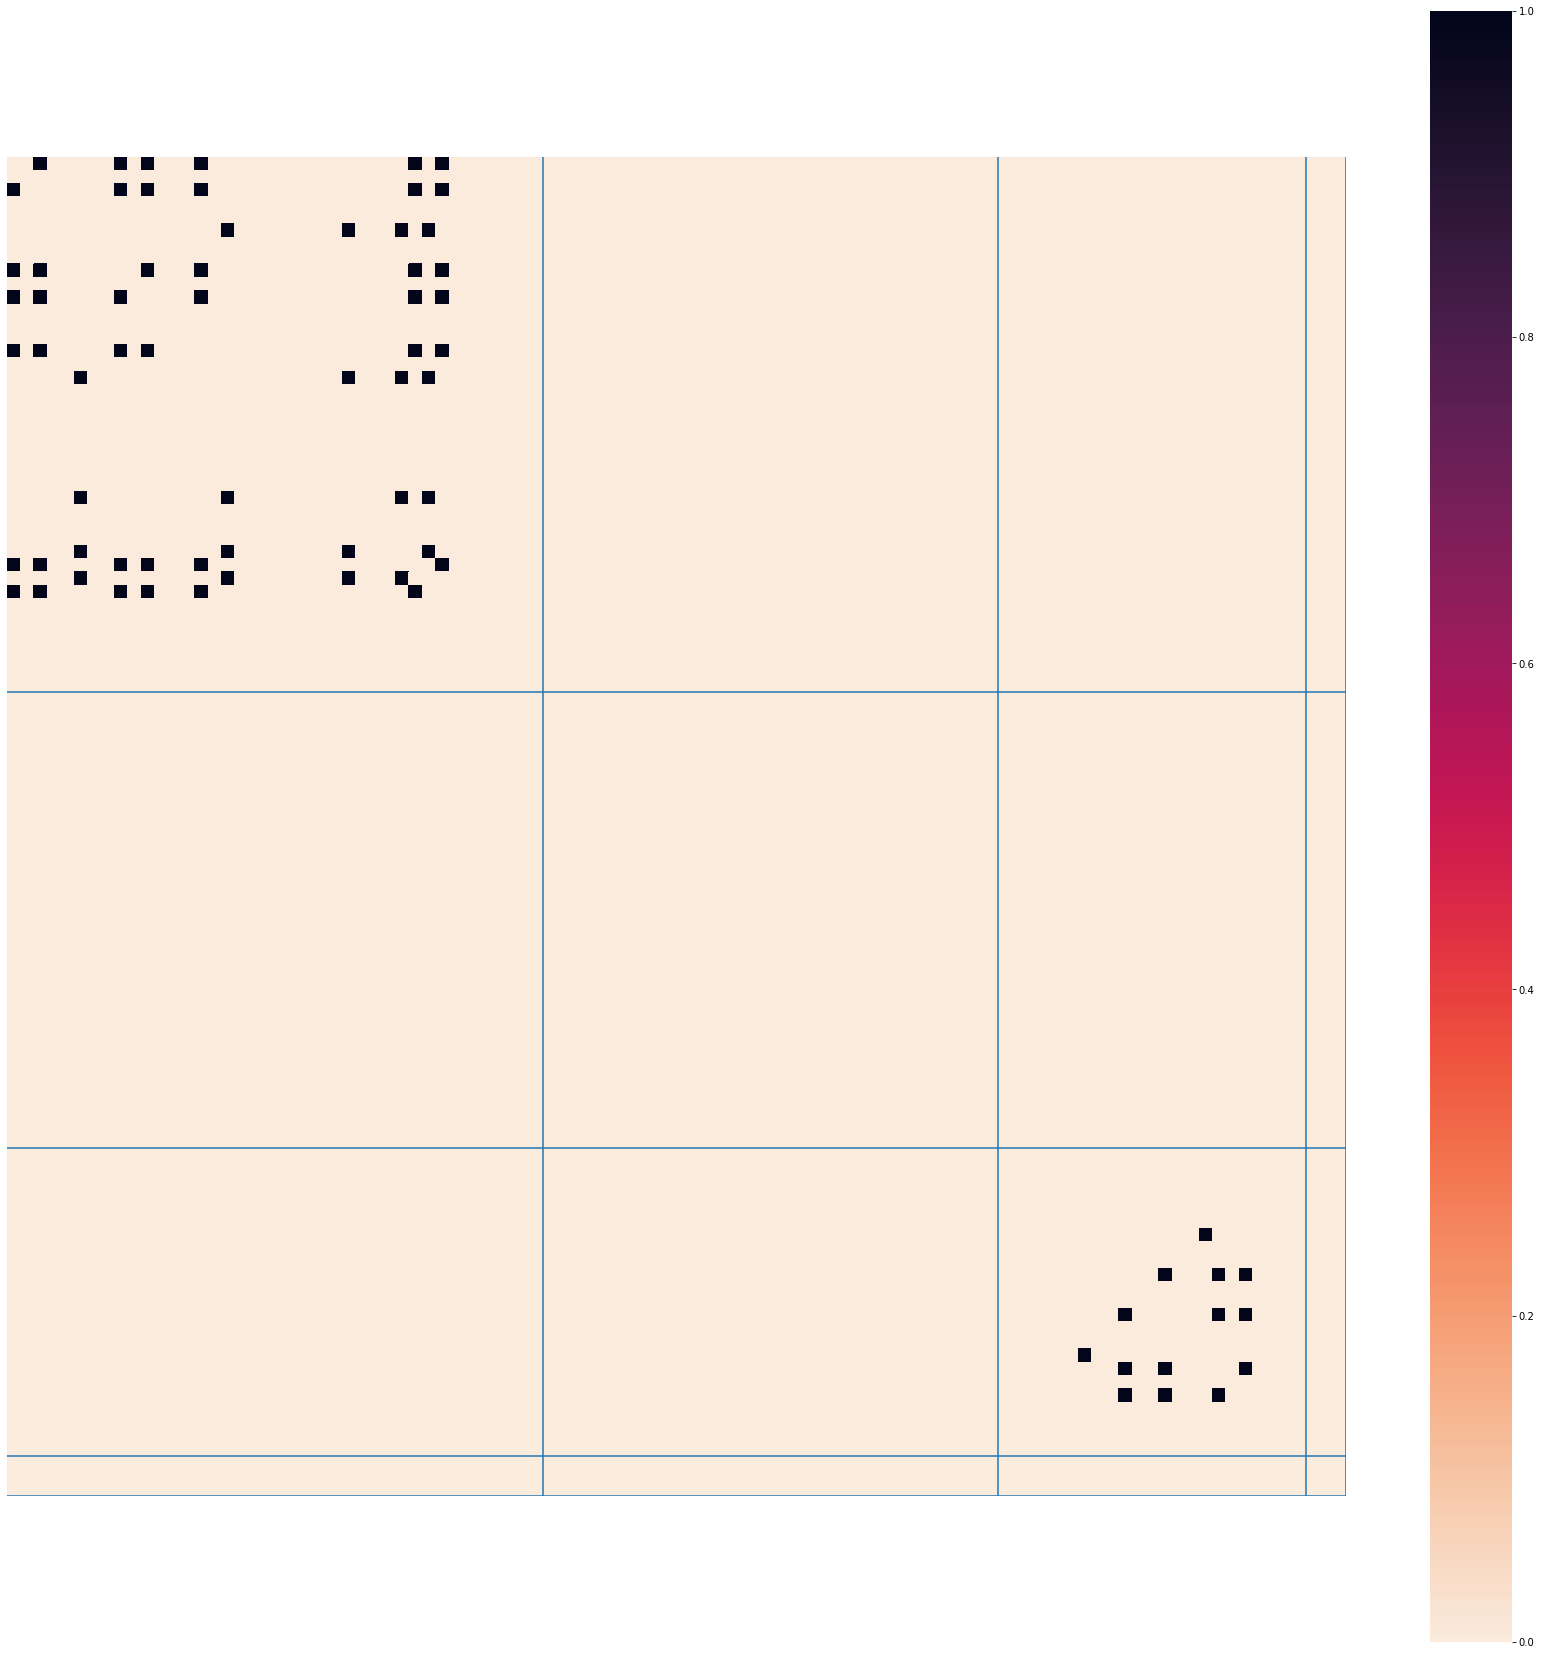

In [42]:
# TODO: leading diagonal should be one (similiarity between identical pair) but is zero

_, ax = plt.subplots(figsize=(30,30))
sns.heatmap(Y_sq, ax=ax, square=True, cmap=sns.cm.rocket_r, xticklabels=[], yticklabels=[])

ax.hlines([v for v in mention_sample['type'].value_counts().cumsum()], *ax.get_xlim())
ax.vlines([v for v in mention_sample['type'].value_counts().cumsum()], *ax.get_ylim())